In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import csv

import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imba_make_pipeline, Pipeline as ImbaPipeline
from joblib import dump, load

import spacy

In [9]:
data = pd.read_csv("cyai-2.tsv", sep="\t")
data = data[data['is_ethics'].notna()]
data

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ai,clf_is_ai_prob,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0.0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0,0.290394
1,abs1910.02390,2019-10-06,1.0,0.0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.293560
2,abs1405.1605,2014-05-07,1.0,0.0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.255565
3,abs1907.04534,2019-07-10,1.0,1.0,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,0.780997
4,abs1906.04272,2019-06-10,1.0,1.0,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,1,0.751128
5,abs1707.06939,2017-07-21,1.0,0.0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0,0.255658
6,abs1810.02724,2018-10-02,1.0,1.0,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,0.704860
7,abs1904.05643,2019-04-11,1.0,0.0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,0,0.319428
8,abs1903.02706,2019-03-06,1.0,0.0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.242234
9,abs0901.3839,2009-01-24,1.0,0.0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0.293575


In [10]:
nlp = spacy.load("en_core_web_lg")

In [11]:
docs = []
for doc in nlp.pipe(data.description):
    docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [12]:
vectorizer = CountVectorizer(
    max_df = 0.75,
    max_features = None,
    min_df = 2,
)
X = vectorizer.fit_transform(docs)

In [13]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, data.is_ethics)

In [35]:
pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

cross_val_score(pipeline, X_resampled, y_resampled, cv=4, scoring = "roc_auc", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.9s finished


array([0.99795841, 0.99826087, 1.        , 1.        ])

In [28]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv='warn', n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score='raise-deprecating')
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be for example a list, or an array.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentat

In [14]:
pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

In [15]:
pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l1', smooth_idf=True, sublinear_tf=False,
         use_idf=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, mi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
y_pred = pipeline.predict(X)
y_prob = pipeline.predict_proba(X)

In [17]:
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, y_pred))

confusion_matrix [[460   0]
 [  0  82]]
f1_score 1.0
precision_score 1.0
recall_score 1.0
accuracy_score 1.0
roc_auc_score 1.0


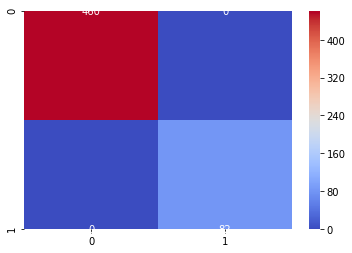

In [18]:
sns.heatmap(confusion_matrix(data.is_ethics, y_pred), annot=True, fmt="d", cmap="coolwarm")

In [19]:
confidence_margin = 0.33

print(sum(np.logical_or(y_prob[:,1]<confidence_margin, y_prob[:,1]>1-confidence_margin)))
print(sum(y_prob[:,1]>1-confidence_margin))

416
58


In [20]:
data_full = pd.read_csv("cyai-full.tsv", sep="\t")

In [21]:
data_full

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ai,clf_is_ai_prob,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0.0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,abs1910.02390,2019-10-06,1.0,0.0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
2,abs1405.1605,2014-05-07,1.0,0.0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
3,abs1907.04534,2019-07-10,1.0,1.0,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,abs1906.04272,2019-06-10,1.0,1.0,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
5,abs1707.06939,2017-07-21,1.0,0.0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,abs1810.02724,2018-10-02,1.0,1.0,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
7,abs1904.05643,2019-04-11,1.0,0.0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
8,abs1903.02706,2019-03-06,1.0,0.0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
9,abs0901.3839,2009-01-24,1.0,0.0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [22]:
docs_full = []
for doc in nlp.pipe(data_full.description):
    docs_full.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [23]:
X_full = vectorizer.transform(docs_full)

In [24]:
y_full_pred = pipeline.predict(X_full)
y_full_prob = pipeline.predict_proba(X_full)

In [25]:
data_full["clf_is_ethics"] = y_full_pred
data_full["clf_is_ethics_prob"] = y_full_prob[:,1]

In [26]:
data_full

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ai,clf_is_ai_prob,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0.0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.383240
1,abs1910.02390,2019-10-06,1.0,0.0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.379631
2,abs1405.1605,2014-05-07,1.0,0.0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.300291
3,abs1907.04534,2019-07-10,1.0,1.0,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,0.733579
4,abs1906.04272,2019-06-10,1.0,1.0,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,1.0,0.592441
5,abs1707.06939,2017-07-21,1.0,0.0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.287950
6,abs1810.02724,2018-10-02,1.0,1.0,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,0.710515
7,abs1904.05643,2019-04-11,1.0,0.0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.372337
8,abs1903.02706,2019-03-06,1.0,0.0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,0.287313
9,abs0901.3839,2009-01-24,1.0,0.0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.332034


In [27]:
data_full.to_csv('cyai-clf-2.tsv',sep='\t',index=False,header=True, quoting=csv.QUOTE_NONE)

In [37]:
dump(pipeline, "imba_pipeline-2.joblib")

['imba_pipeline-2.joblib']